<a href="https://colab.research.google.com/github/rl-cyber/User-Engaged-Network-Diagnosis/blob/main/Spec_CVEs_match.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# =============================================
# Full Pipeline: Specification Inconsistency × CVE Matching with Protocol Feature Boosting
# =============================================

# Install dependencies
!pip install -U sentence-transformers faiss-cpu

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import faiss


# Path to your files (adjust if needed)
conflict_path = "/content/conflict_segments_gpt_enhanced.xlsx"
cve_path = "/content/cve_dataset_with_inferred_symptoms.csv"

# Load CSVs
conflict_df = pd.read_excel(conflict_path)
cve_df = pd.read_csv(cve_path)

print(f"Loaded {len(conflict_df)} spec inconsistencies and {len(cve_df)} CVEs.")

# Combine message/state info into spec conflict text
conflict_texts = (
    conflict_df['conflict_explanation'].fillna('') + " " +
    conflict_df['message_gpt'].fillna('') + " " +
    conflict_df['state_gpt'].fillna('')
).tolist()

# Combine description and symptoms for CVEs
cve_texts = (
    cve_df['detailed_description'].fillna('') + " " +
    cve_df['inferred_user_symptoms'].fillna('')
).tolist()


model = SentenceTransformer('all-mpnet-base-v2')

conflict_embeddings = model.encode(conflict_texts, batch_size=64, normalize_embeddings=True)
cve_embeddings = model.encode(cve_texts, batch_size=64, normalize_embeddings=True)

print(f"Generated embeddings: {conflict_embeddings.shape} (specs), {cve_embeddings.shape} (CVEs)")


faiss.normalize_L2(cve_embeddings)
index = faiss.IndexFlatIP(cve_embeddings.shape[1])
index.add(cve_embeddings)

faiss.normalize_L2(conflict_embeddings)
k = 5  # top 5 candidates
scores, indices = index.search(conflict_embeddings, k)

print(f"Top-{k} matching done.")

# =============================================
# Protocol Feature Boosting
# =============================================

def protocol_feature_boosting(conflict_row, cve_row, base_score, boost_weight=0.05):
    boosted_score = base_score
    conflict_message = str(conflict_row.get('message_gpt', '')).lower()
    conflict_state = str(conflict_row.get('state_gpt', '')).lower()
    cve_text = str(cve_row.get('detailed_description', '')).lower()

    if conflict_message and conflict_message in cve_text:
        boosted_score += boost_weight
    if conflict_state and conflict_state in cve_text:
        boosted_score += boost_weight
    return boosted_score

# Collect matches
results = []

for conflict_idx, top_cve_indices in enumerate(indices):
  conflict_row = conflict_df.iloc[conflict_idx]
  for rank, cve_idx in enumerate(top_cve_indices):
        cve_row = cve_df.iloc[cve_idx]
        base_score = scores[conflict_idx][rank]
        boosted_score = protocol_feature_boosting(conflict_row, cve_row, base_score)

        results.append({
            "conflict_id": conflict_row['conflict_id'],
            "conflict_message": conflict_row.get('message_gpt', ''),
            "conflict_state": conflict_row.get('state_gpt', ''),
            "conflict_explanation": conflict_row.get('conflict_explanation', ''),
            "conflict_effect": conflict_row.get('effect_gpt', ''),
            "cve_id": cve_row['cve_id'],
            "cve_description": cve_row['detailed_description'],
            "cve_effect": cve_row.get('inferred_user_symptoms', ''),
            "base_similarity_score": base_score,
            "boosted_similarity_score": boosted_score,
        })

# Save
boosted_df = pd.DataFrame(results)
boosted_df.to_csv("/content/boosted_spec_to_cve_matches_full.csv", index=False)


print(f"Saved final boosted matching results")


Loaded 1018 spec inconsistencies and 350 CVEs.
Generated embeddings: (1018, 768) (specs), (350, 768) (CVEs)
Top-5 matching done.
Saved final boosted matching results


In [5]:
boosted_df = pd.DataFrame(results)

# Sort by boosted score
boosted_df.sort_values(by=["conflict_id", "boosted_similarity_score"], ascending=[True, False], inplace=True)

# Keep only top-1 per conflict
boosted_df = boosted_df.drop_duplicates(subset="conflict_id", keep="first")

# Save
boosted_df.to_csv("/content/boosted_spec_to_cve_matches_top1.csv", index=False)

print("Saved only Top-1 matches per spec conflict.")

Saved only Top-1 matches per spec conflict.


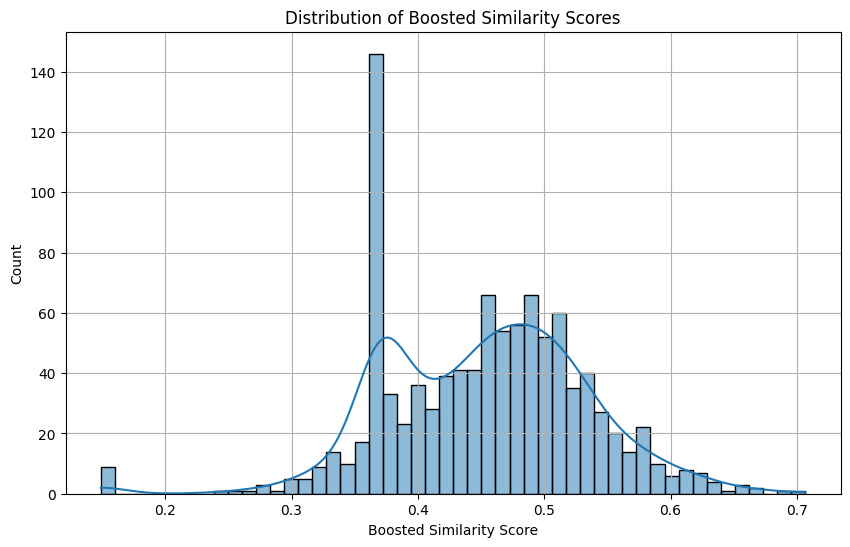

In [6]:
# =============================================
# Plotting Boosted Similarity Score Histogram
# =============================================

import matplotlib.pyplot as plt
import seaborn as sns

# Load boosted results
boosted_df = pd.read_csv("/content/boosted_spec_to_cve_matches_top1.csv")

# Plot histogram
plt.figure(figsize=(10,6))
sns.histplot(boosted_df['boosted_similarity_score'], bins=50, kde=True)

plt.title('Distribution of Boosted Similarity Scores')
plt.xlabel('Boosted Similarity Score')
plt.ylabel('Count')
plt.grid(True)
plt.show()


In [9]:
# ============================================================
# Filter, Select and Save Cleaned Spec-to-CVE Matches
# ============================================================

import pandas as pd

# Load the raw matching results
data_path = "/content/boosted_spec_to_cve_matches_top1.csv"  # adjust path if needed
matches_df = pd.read_csv(data_path)


# Set a threshold
SIMILARITY_THRESHOLD = 0.6

# Filter matches
filtered_df = matches_df[matches_df['boosted_similarity_score'] >= SIMILARITY_THRESHOLD]
print(f"Remaining matches after filtering: {len(filtered_df)}")


# Sort by conflict_id and similarity_score descending
filtered_df = filtered_df.sort_values(by=["conflict_id", "boosted_similarity_score"], ascending=[True, False])

output_path = "/content/spec_to_cve_matches_filtered.csv"
filtered_df.to_csv(output_path, index=False)

print(f"Cleaned Top-1 matches saved to {output_path}")

filtered_df.head(10)

Remaining matches after filtering: 33
Cleaned Top-1 matches saved to /content/spec_to_cve_matches_filtered.csv


,conflict_id,conflict_message,conflict_state,conflict_explanation,conflict_effect,cve_id,cve_description,cve_effect,base_similarity_score,boosted_similarity_score
17,C017,NAS messages,EPS security context,Replay protection shall be supported for recei...,Potential replay attack vulnerability when EIA...,CVE-2023-37367,An issue was discovered in Samsung Exynos Mobi...,Unknown,0.579121,0.629121
20,C020,NAS message,NAS COUNT close to wrap around,"If, when increasing the NAS COUNT as specified...",Potential security context reset or connection...,CVE-2023-37367,An issue was discovered in Samsung Exynos Mobi...,Unknown,0.566005,0.616005
22,C022,Various NAS signalling messages,Secure exchange not established,"Except the messages listed below, no NAS signa...",Potential processing of unprotected messages,CVE-2023-37367,An issue was discovered in Samsung Exynos Mobi...,Unknown,0.623000,0.623000
34,C034,ATTACH REJECT,EMM cause #78,The UE may be rejected with EMM cause #78 in A...,Restricted access to certain PLMNs via satelli...,CVE-2024-23353,Transient DOS while decoding attach reject mes...,Unknown,0.572376,0.622376
135,C121,EMM uplink message,Not specified,The following abnormal case can be identified ...,Possible need for retransmission with new sequ...,CVE-2024-23353,Transient DOS while decoding attach reject mes...,Unknown,0.634833,0.634833
174,C160,SECURITY MODE REJECT,During security mode control procedure,If the security mode command cannot be accepte...,Abort ongoing procedure and revert to previous...,CVE-2023-37367,An issue was discovered in Samsung Exynos Mobi...,Unknown,0.619778,0.619778
175,C161,SECURITY MODE COMPLETE or SECURITY MODE REJECT,Triggered by tracking area updating,The following abnormal cases can be identified...,Aborted security mode control procedure with p...,CVE-2024-38426,While processing the authentication message in...,Unknown,0.617060,0.617060
180,C166,IDENTITY REQUEST,EMM-CONNECTED,A UE shall be ready to respond to an IDENTITY ...,UE must respond with IDENTITY RESPONSE contain...,CVE-2024-38426,While processing the authentication message in...,Unknown,0.610099,0.610099
182,C168,IDENTITY RESPONSE,Various (depending on triggering procedure),The following abnormal cases can be identified...,Abnormal handling of identification procedure ...,CVE-2024-38426,While processing the authentication message in...,Unknown,0.691857,0.691857
198,C184,NaN,NaN,If the attach request cannot be accepted by th...,NaN,CVE-2024-23353,Transient DOS while decoding attach reject mes...,Unknown,0.620449,0.620449


In [10]:
# Matching statistics
num_conflicts = filtered_df['conflict_id'].nunique()
avg_similarity = filtered_df['boosted_similarity_score'].mean()
std_similarity = filtered_df['boosted_similarity_score'].std()

print(f"Matched {num_conflicts} specification conflicts to CVEs.")
print(f"Average similarity score: {avg_similarity:.4f} (Std: {std_similarity:.4f})")


Matched 33 specification conflicts to CVEs.
Average similarity score: 0.6292 (Std: 0.0262)


In [11]:
# ============================================================
# LLM-Assisted Validation of Spec-to-CVE Matches
# ============================================================

!pip install -q openai
import pandas as pd
import openai
import time

# Set your OpenAI API key
openai.api_key = "XXXX"  # Replace with your actual key

# Load Top-1 filtered matches
data_path = "/content/spec_to_cve_matches_filtered.csv"
matches_df = pd.read_csv(data_path)

# ---------------------- Define GPT Prompt Function ----------------------

def build_validation_prompt(row):
    return f"""
You are a cellular security analyst.

Given the following information:
- Spec Inconsistency Explanation: {row['conflict_effect']}
- Matched CVE Description: {row['cve_description']}
- Inferred User Symptoms: {row['cve_effect']}

Task:
1. Is there a plausible causal link between the spec inconsistency and the CVE? (Answer only YES or NO)
2. Are the expected user symptoms aligned with the CVE description? (Answer only ALIGNED or NOT ALIGNED)
3. Give your confidence in the mapping (number between 0 and 10).
4. Briefly explain your reasoning (1 sentences).
"""

def gpt_validate(row):
    try:
        prompt = build_validation_prompt(row)
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.1,
            max_tokens=200
        )
        content = response.choices[0].message.content
        return content
    except Exception as e:
        print("Error:", e)
        return "GPT_ERROR"

validation_outputs = []

for idx, row in matches_df.iterrows():
    print(f"Processing {row['conflict_id']} ↔ {row['cve_id']}...")
    output = gpt_validate(row)
    validation_outputs.append(output)
    time.sleep(1.2)  # to avoid hitting rate limits

matches_df['gpt_validation_output'] = validation_outputs


output_path = "/content/spec_to_cve_matches_validated_gpt.csv"
matches_df.to_csv(output_path, index=False)

print(f"GPT-assisted validation complete. Results saved to {output_path}")


Processing C017 ↔ CVE-2023-37367...
Processing C020 ↔ CVE-2023-37367...
Processing C022 ↔ CVE-2023-37367...
Processing C034 ↔ CVE-2024-23353...
Processing C121 ↔ CVE-2024-23353...
Processing C160 ↔ CVE-2023-37367...
Processing C161 ↔ CVE-2024-38426...
Processing C166 ↔ CVE-2024-38426...
Processing C168 ↔ CVE-2024-38426...
Processing C184 ↔ CVE-2024-23353...
Processing C191 ↔ CVE-2024-23353...
Processing C200 ↔ CVE-2024-23353...
Processing C215 ↔ CVE-2024-23353...
Processing C231 ↔ CVE-2024-23353...
Processing C253 ↔ CVE-2023-32890...
Processing C259 ↔ CVE-2024-20149...
Processing C260 ↔ CVE-2023-32890...
Processing C265 ↔ CVE-2024-23353...
Processing C271 ↔ CVE-2024-23353...
Processing C277 ↔ CVE-2023-37367...
Processing C283 ↔ CVE-2023-37367...
Processing C295 ↔ CVE-2024-38426...
Processing C314 ↔ CVE-2024-23353...
Processing C422 ↔ CVE-2024-38426...
Processing C455 ↔ CVE-2024-23353...
Processing C492 ↔ CVE-2024-23353...
Processing C521 ↔ CVE-2024-38426...
Processing C523 ↔ CVE-2024-3

In [12]:
# ============================================================
# Post-Process GPT Validation Outputs and Summarize
# ============================================================

import pandas as pd
import re

# Load the validated matches
data_path = "/content/spec_to_cve_matches_validated_gpt.csv"
matches_df = pd.read_csv(data_path)


def extract_field(pattern, text):
    match = re.search(pattern, text, re.IGNORECASE)
    if match:
        return match.group(1).strip()
    else:
        return "UNKNOWN"

def parse_gpt_output(text):
    causal_link = extract_field(r"1\.\s*.*?\b(YES|NO)\b", text)
    symptom_alignment = extract_field(r"2\.\s*.*?\b(ALIGNED|NOT ALIGNED)\b", text)
    confidence = extract_field(r"3\.\s*.*?(\d{1,3})", text)
    reasoning = extract_field(r"4\.\s*(.+)", text)
    return causal_link, symptom_alignment, confidence, reasoning

# Apply parsing
causal_links, symptom_alignments, confidence_scores, reasonings = [], [], [], []

for output in matches_df['gpt_validation_output']:
    causal_link, symptom_alignment, confidence, reasoning = parse_gpt_output(output)
    causal_links.append(causal_link)
    symptom_alignments.append(symptom_alignment)
    confidence_scores.append(confidence)
    reasonings.append(reasoning)

matches_df['causal_link_gpt'] = causal_links
matches_df['symptom_alignment_gpt'] = symptom_alignments
matches_df['confidence_score_gpt'] = confidence_scores
matches_df['reasoning_gpt'] = reasonings


output_path = "/content/spec_to_cve_matches_validated_parsed.csv"
matches_df.to_csv(output_path, index=False)
print(f"Parsed validation results saved to {output_path}")


# Convert confidence scores to numeric
matches_df['confidence_score_gpt'] = pd.to_numeric(matches_df['confidence_score_gpt'], errors='coerce')

# Calculate stats
num_matches = len(matches_df)
causal_yes = (matches_df['causal_link_gpt'] == 'YES').sum()
symptom_aligned = (matches_df['symptom_alignment_gpt'] == 'ALIGNED').sum()
avg_confidence = matches_df['confidence_score_gpt'].mean()

print("\n Validation Summary:")
print(f"- Total Matches Validated: {num_matches}")
print(f"- Causal Links Found: {causal_yes} ({causal_yes/num_matches*100:.2f}%)")
print(f"- Symptom Alignment: {symptom_aligned} ({symptom_aligned/num_matches*100:.2f}%)")
print(f"- Average Confidence Score: {avg_confidence:.2f}")

Parsed validation results saved to /content/spec_to_cve_matches_validated_parsed.csv

 Validation Summary:
- Total Matches Validated: 33
- Causal Links Found: 25 (75.76%)
- Symptom Alignment: 19 (57.58%)
- Average Confidence Score: 7.48


In [13]:
filtered_matches = matches_df[
    (matches_df['causal_link_gpt'] == 'YES') &
    (matches_df['confidence_score_gpt'] >= 7)
]
filtered_matches.to_csv("/content/spec_to_cve_final_high_confidence.csv", index=False)
print(f"Final high-confidence matches: {len(filtered_matches)}")

Final high-confidence matches: 25


Average similarity of validated matches: 0.63
Average GPT confidence: 7.84
Number of validated matches: 25


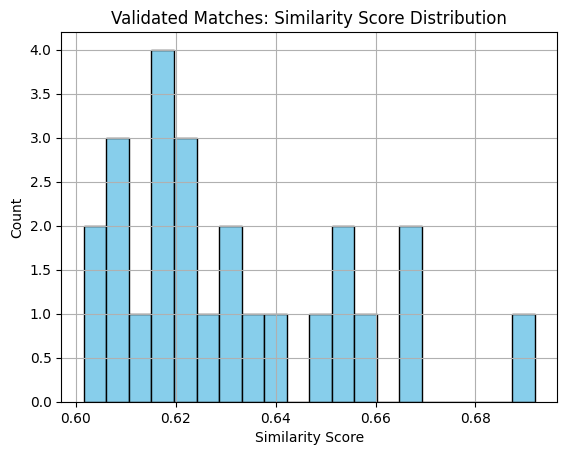

In [15]:
avg_similarity = filtered_matches['boosted_similarity_score'].mean()
avg_confidence = filtered_matches['confidence_score_gpt'].mean()

print(f"Average similarity of validated matches: {avg_similarity:.2f}")
print(f"Average GPT confidence: {avg_confidence:.2f}")
print(f"Number of validated matches: {len(filtered_matches)}")

import matplotlib.pyplot as plt

# Similarity
plt.hist(filtered_matches['boosted_similarity_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Validated Matches: Similarity Score Distribution')
plt.xlabel('Similarity Score')
plt.ylabel('Count')
plt.grid(True)
plt.show()